In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.losses import MeanAbsoluteError
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,  mean_squared_error, r2_score

In [ ]:
train_csv = pd.read_csv("/content/drive/MyDrive/ML Medicine/HCG18/train_set_pixel_size_and_HC.csv")
train_dir = "/content/drive/MyDrive/ML Medicine/HCG18/train_set"

test_csv = pd.read_csv("/content/drive/MyDrive/ML Medicine/HCG18/test_set_pixel_size.csv")
test_dir = "/content/drive/MyDrive/ML Medicine/HCG18/test_set"

In [ ]:
train_csv.head()


,filename,pixel size(mm),HC (mm)
0,000_HC.png,0.069136,44.30
1,001_HC.png,0.089659,56.81
2,002_HC.png,0.062033,68.75
3,003_HC.png,0.091291,69.00
4,004_HC.png,0.061240,59.81


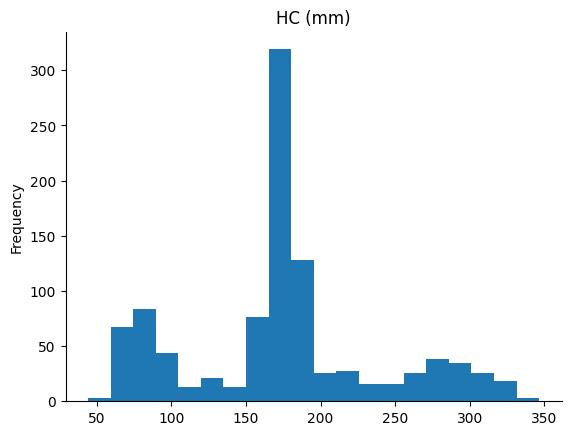

In [ ]:
# @title HC (mm)

from matplotlib import pyplot as plt
train_csv['HC (mm)'].plot(kind='hist', bins=20, title='HC (mm)')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
train_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   filename        999 non-null    object 
 1   pixel size(mm)  999 non-null    float64
 2   HC (mm)         999 non-null    float64
dtypes: float64(2), object(1)
memory usage: 23.5+ KB


In [ ]:
test_csv.head()

,filename,pixel size(mm)
0,000_HC.png,0.235857
1,001_HC.png,0.067973
2,002_HC.png,0.165202
3,003_HC.png,0.096674
4,004_HC.png,0.202203


In [ ]:
len(train_csv)


999

In [ ]:
len(test_csv)

335

In [ ]:

image_ids = train_csv["filename"]
hc_values = train_csv["HC (mm)"].values

In [ ]:
def load_image(img_id):
    img_path = os.path.join(train_dir, img_id)
    if not os.path.exists(img_path):
        return np.zeros((224, 224, 3), dtype=np.uint8)

    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = preprocess_input(img)
    return img

X_data = np.array([load_image(img_id) for img_id in image_ids])
y_data = np.array(hc_values)

X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

print(f" Train size: {X_train.shape}, Validation size: {X_val.shape}")

 Train size: (799, 224, 224, 3), Validation size: (200, 224, 224, 3)


In [ ]:
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.3)(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.3)(x)
x = Dense(1, activation="linear")(x)

model = Model(inputs=base_model.input, outputs=x)

model.compile(optimizer=Adam(learning_rate=0.0001), loss=MeanAbsoluteError(), metrics=["mae"])

model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 24,768,385 (94.48 MB)

 Trainable params: 1,180,673 (4.50 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
history = model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = 10, batch_size = 32, verbose = 1)


Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 204s 8s/step - loss: 163.8969 - mae: 163.8969 - val_loss: 133.1739 - val_mae: 133.1739
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 200s 8s/step - loss: 111.3846 - mae: 111.3846 - val_loss: 52.5014 - val_mae: 52.5014
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 207s 8s/step - loss: 50.5185 - mae: 50.5185 - val_loss: 43.3703 - val_mae: 43.3703
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 199s 8s/step - loss: 45.9794 - mae: 45.9794 - val_loss: 40.5182 - val_mae: 40.5182
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 203s 8s/step - loss: 43.0976 - mae: 43.0976 - val_loss: 37.7390 - val_mae: 37.7390
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 194s 8s/step - loss: 39.5653 - mae: 39.5653 - val_loss: 33.6501 - val_mae: 33.6501
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 195s 8s/step - loss: 34.9083 - mae: 34.9083 - val_loss: 29.8392 - val_mae: 29.8392
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 238s 9s/step - loss: 33.4770 - mae: 33.4770 - val_loss: 26.2802 - val_mae: 26.2802
Epoch 9/10
25/25 ━━━━━━━━━

In [ ]:
y_pred = model.predict(X_val).flatten()

mae = mean_absolute_error(y_val, y_pred)

mse = mean_squared_error(y_val, y_pred)

rmse = np.sqrt(mse)

r2 = r2_score(y_val, y_pred)

print(" Regression Model Evaluation:  ")
print(f" MAE  = {mae:.2f} mm")
print(f" MSE  = {mse:.2f}")
print(f" RMSE = {rmse:.2f}")
print(f" R² Score = {r2:.4f}")




7/7 ━━━━━━━━━━━━━━━━━━━━ 46s 6s/step
 Regression Model Evaluation:  
 MAE  = 22.69 mm
 MSE  = 945.79
 RMSE = 30.75
 R² Score = 0.7656


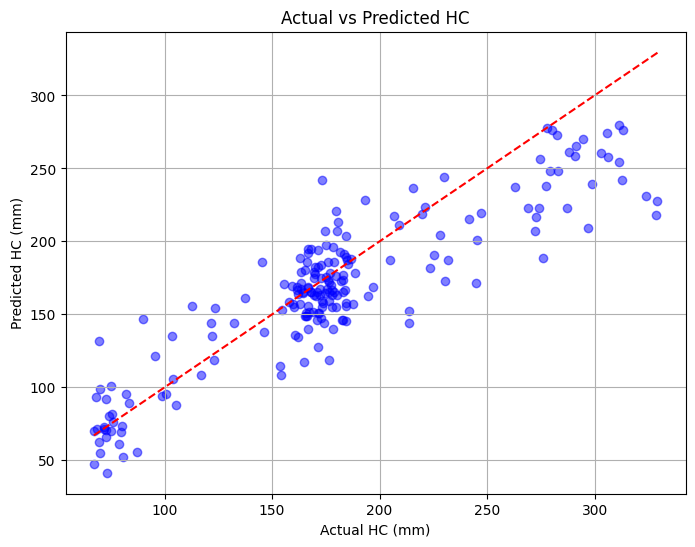

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(y_val, y_pred, alpha=0.5, color='blue')
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], '--', color='red')
plt.xlabel("Actual HC (mm)")
plt.ylabel("Predicted HC (mm)")
plt.title("Actual vs Predicted HC")
plt.grid(True)
plt.show()


Head Circumference (HC) Statistics (mm):
count    999.000000
mean     174.383093
std       65.282061
min       44.300000
25%      153.600000
50%      174.060000
75%      189.825000
max      346.400000
Name: HC (mm), dtype: float64


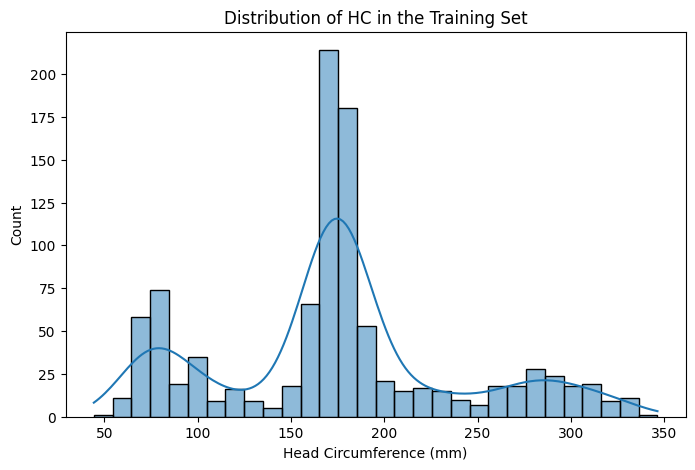

In [ ]:
print("\nHead Circumference (HC) Statistics (mm):")
print(train_csv["HC (mm)"].describe())

plt.figure(figsize=(8, 5))
sns.histplot(train_csv["HC (mm)"], bins=30, kde=True)
plt.xlabel("Head Circumference (mm)")
plt.ylabel("Count")
plt.title("Distribution of HC in the Training Set")
plt.show()


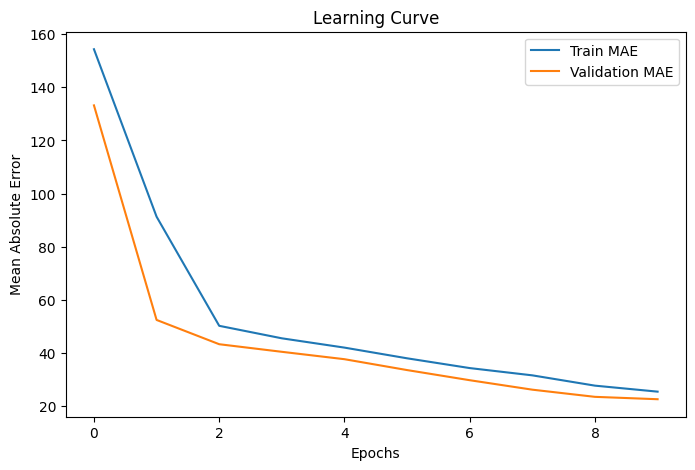

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(history.history["mae"], label="Train MAE")
plt.plot(history.history["val_mae"], label="Validation MAE")
plt.xlabel("Epochs")
plt.ylabel("Mean Absolute Error")
plt.title("Learning Curve")
plt.legend()
plt.show()

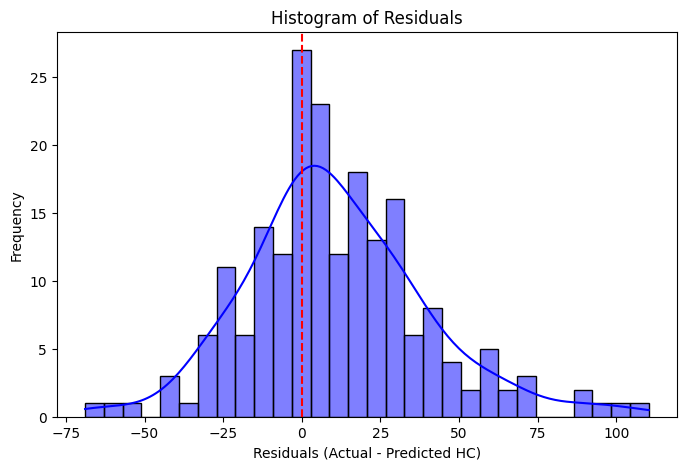

In [ ]:
residuals = y_val - y_pred.flatten()
plt.figure(figsize=(8, 5))
sns.histplot(residuals, bins=30, kde=True, color="blue")
plt.axvline(0, color='red', linestyle='--')
plt.xlabel("Residuals (Actual - Predicted HC)")
plt.ylabel("Frequency")
plt.title("Histogram of Residuals")
plt.show()


In [ ]:
test_image_ids = test_csv["filename"]

X_test = np.array([load_image(img_id) for img_id in test_image_ids])

y_test_pred = model.predict(X_test)

test_csv["Predicted_HC (mm)"] = y_test_pred
test_csv.to_csv("predicted_test_HC.csv", index=False)




11/11 ━━━━━━━━━━━━━━━━━━━━ 64s 6s/step
